In [1]:
import numpy as np
import xarray as xr
import pandas as pd
# from dask.diagnostics import ProgressBar
from xgcm.grid import Grid
import xrft
import gsw
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import scipy.io
import os
from scipy.interpolate import interp1d

%matplotlib inline
# ProgressBar().register()

In [2]:
!pip install seawater

# Load data

In [3]:
from intake import open_catalog
import xmitgcm.llcreader as llcreader
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml")

u = cat.LLC4320_SSU.to_dask()
v = cat.LLC4320_SSV.to_dask()
ssh = cat.LLC4320_SSH.to_dask()
ds = xr.merge([u, v,ssh])
ds = llcreader.llcmodel.faces_dataset_to_latlon(ds, metric_vector_pairs=[])

# reset_coords()则是将坐标变量转换为数据变量
coords = cat.LLC4320_grid.to_dask().reset_coords()
coords = llcreader.llcmodel.faces_dataset_to_latlon(coords)

In [4]:
coords.XC.min().values

array(-179.99998, dtype=float32)

In [5]:
aim_location = np.logical_and(np.logical_and(coords.XC>120, coords.XC<175 ), 
                           np.logical_and(coords.YC>5, coords.YC<50 ))
aim_location

<xarray.DataArray 'XC' (j: 12960, i: 17280)>
dask.array<logical_and, shape=(12960, 17280), dtype=bool, chunksize=(4320, 4320), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959

In [6]:
%%time
ds_sel = ds.where(aim_location, drop=True)

CPU times: user 1min 11s, sys: 28.5 s, total: 1min 40s
Wall time: 27.4 s


In [7]:
%%time
coords2 = coords.where(aim_location, drop=True)

CPU times: user 2min 41s, sys: 59.5 s, total: 3min 41s
Wall time: 51.4 s


In [8]:
ds_sel

<xarray.Dataset>
Dimensions:  (time: 9030, j: 2746, i_g: 17280, i: 2640, j_g: 12960, face: 13)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 0 1 2 3 4 5 6 ... 17274 17275 17276 17277 17278 17279
  * j        (j) int64 8179 8180 8181 8182 8183 ... 10921 10922 10923 10924
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * i        (i) int64 7584 7585 7586 7587 7588 ... 10220 10221 10222 10223
  * j_g      (j_g) int64 0 1 2 3 4 5 6 ... 12954 12955 12956 12957 12958 12959
Data variables:
    U        (time, j, i_g, i) float32 dask.array<chunksize=(1, 461, 4320, 1056), meta=np.ndarray>
    V        (time, j_g, i, j) float32 dask.array<chunksize=(1, 4320, 1056, 461), meta=np.ndarray>
    Eta      (time, j, i) float32 dask.array<chunksize=(1, 461, 1056), meta=np.ndarray>

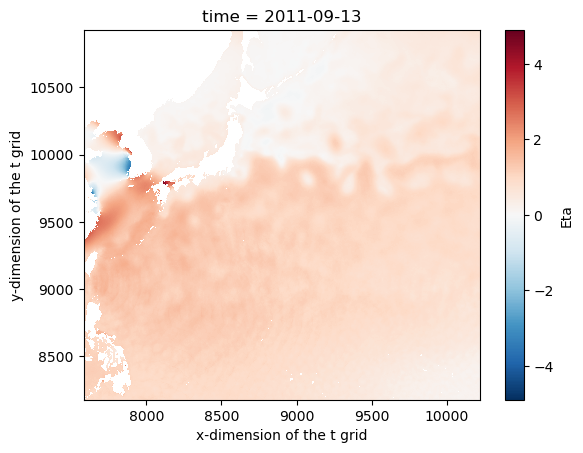

In [9]:
ds_sel.Eta.isel(time=0).plot()

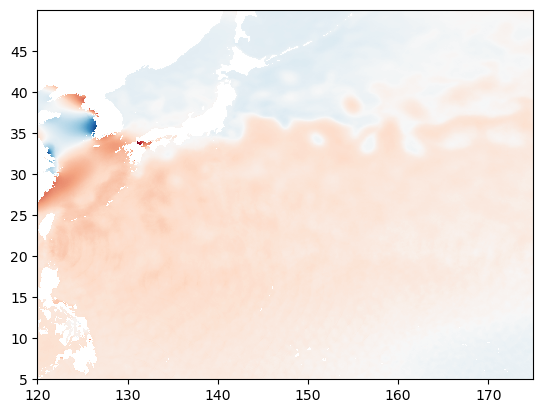

In [10]:
plt.pcolormesh(coords2.XC, coords2.YC,ds_sel.Eta.isel(time=0),cmap='RdBu_r')

In [11]:
i1 = ds_sel.i[0].values
i2 = ds_sel.i[-1].values+1
j1 = ds_sel.j[0].values
j2 = ds_sel.j[-1].values+1
i1,i2,j1,j2

(array(7584), 10224, array(8179), 10925)

In [12]:
# dxC_sel = coords.dxC.isel(i_g=slice(i1, i2), j=slice(j1, j2))
# dyG_sel = coords.dyG.isel(i_g=slice(i1, i2), j=slice(j1, j2))
# dyC_sel = coords.dyC.isel(i=slice(i1, i2), j_g=slice(j1, j2))
# dxG_sel = coords.dxG.isel(i=slice(i1, i2), j_g=slice(j1, j2))
# XC_sel = coords.XC.isel(i=slice(i1, i2), j=slice(j1, j2))
# YC_sel = coords.YC.isel(i=slice(i1, i2), j=slice(j1, j2))

step = 12  # 间隔

dxC_sel = coords.dxC.isel(i_g=slice(i1, i2, step), j=slice(j1, j2, step))
dyG_sel = coords.dyG.isel(i_g=slice(i1, i2, step), j=slice(j1, j2, step))
dyC_sel = coords.dyC.isel(i=slice(i1, i2, step), j_g=slice(j1, j2, step))
dxG_sel = coords.dxG.isel(i=slice(i1, i2, step), j_g=slice(j1, j2, step))
XC_sel = coords.XC.isel(i=slice(i1, i2, step), j=slice(j1, j2, step))
YC_sel = coords.YC.isel(i=slice(i1, i2, step), j=slice(j1, j2, step))


In [13]:
llc_var = ds.sel(time=slice('2011-09-13','2012-09-13')).isel(time=slice(0,None,24),i_g=slice(i1, i2,12), j=slice(j1, j2,12),
                                                         i=slice(i1, i2,12), j_g=slice(j1, j2,12))
llc_var

<xarray.Dataset>
Dimensions:  (face: 13, i_g: 220, j: 229, time: 367, i: 220, j_g: 229)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 7584 7596 7608 7620 7632 ... 10176 10188 10200 10212
  * j        (j) int64 8179 8191 8203 8215 8227 ... 10879 10891 10903 10915
  * time     (time) datetime64[ns] 2011-09-13 2011-09-14 ... 2012-09-13
  * i        (i) int64 7584 7596 7608 7620 7632 ... 10176 10188 10200 10212
  * j_g      (j_g) int64 8179 8191 8203 8215 8227 ... 10879 10891 10903 10915
Data variables:
    U        (time, j, i_g) float32 dask.array<chunksize=(1, 39, 88), meta=np.ndarray>
    V        (time, j_g, i) float32 dask.array<chunksize=(1, 39, 88), meta=np.ndarray>
    Eta      (time, j, i) float32 dask.array<chunksize=(1, 39, 88), meta=np.ndarray>

In [14]:
llcw2 = xr.merge([llc_var,  dxC_sel, dyC_sel, dxG_sel,
                      dyG_sel,XC_sel, YC_sel,dyG_sel])
llcw2

<xarray.Dataset>
Dimensions:  (face: 13, i_g: 220, j: 229, time: 367, i: 220, j_g: 229)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 7584 7596 7608 7620 7632 ... 10176 10188 10200 10212
  * j        (j) int64 8179 8191 8203 8215 8227 ... 10879 10891 10903 10915
  * time     (time) datetime64[ns] 2011-09-13 2011-09-14 ... 2012-09-13
  * i        (i) int64 7584 7596 7608 7620 7632 ... 10176 10188 10200 10212
  * j_g      (j_g) int64 8179 8191 8203 8215 8227 ... 10879 10891 10903 10915
Data variables:
    U        (time, j, i_g) float32 dask.array<chunksize=(1, 39, 88), meta=np.ndarray>
    V        (time, j_g, i) float32 dask.array<chunksize=(1, 39, 88), meta=np.ndarray>
    Eta      (time, j, i) float32 dask.array<chunksize=(1, 39, 88), meta=np.ndarray>
    dxC      (j, i_g) float32 dask.array<chunksize=(39, 88), meta=np.ndarray>
    dyC      (j_g, i) float32 dask.array<chunksize=(39, 88), meta=np.ndarray>
    dxG      (j_g, i) float32 dask.array<chunksize=(39, 88), meta=np.ndarray>
    dyG      (j, i_g) float32 dask.array<chunksize=(39, 88), meta=np.ndarray>
    XC       (j, i) float32 dask.array<chunksize=(39, 88), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(39, 88), meta=np.ndarray>

In [15]:
metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
#     ('Z',): ['drC'], # Z distances
    # ('X', 'Y'): ['rA', 'rAs', 'rAw'] # Areas
}


gridllc = Grid(llcw2, periodic=[],
               coords={
#                        'Z':{'center':'k','outer':'k_p1'},
                       'Y':{'center':'j','left':'j_g'},
                       'X':{'center':'i','left':'i_g'}},
               metrics=metrics
              )
gridllc

<xgcm.Grid>
Y Axis (not periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center
X Axis (not periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center

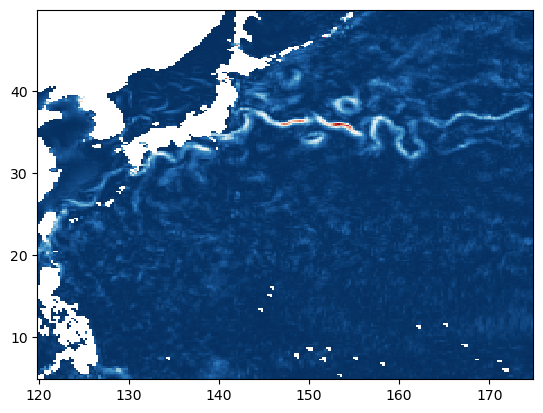

In [16]:
#  统一坐标轴之后，计算KE，坐标不一致无法计算。
tmp=.5*(gridllc.interp(llcw2.U.isel(time=10)**2,'X',boundary='extend')
                       + gridllc.interp(llcw2.V.isel(time=10)**2,'Y',boundary='extend')
                      )
plt.pcolormesh(llcw2.XC, llcw2.YC, tmp,cmap='RdBu_r', vmax=2, vmin=0, rasterized=True, shading='auto')

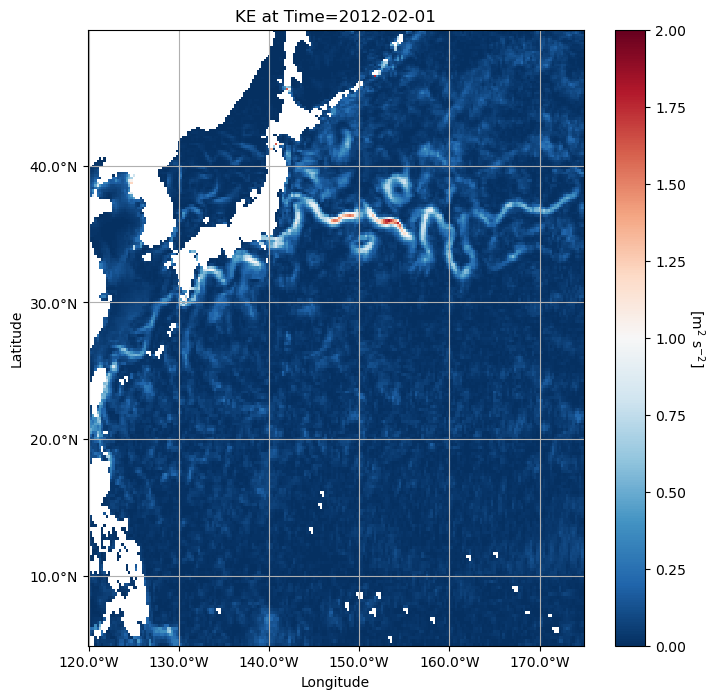

In [17]:
from matplotlib.ticker import FuncFormatter

def format_longitude(x, pos):
    return f"{x:.1f}°W"

def format_latitude(y, pos):
    return f"{y:.1f}°N"

plt.figure(figsize=(8, 8))
plt.pcolormesh(llcw2.XC, llcw2.YC,
              tmp,
               cmap='RdBu_r', vmax=2, vmin=0, rasterized=True, shading='auto')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('KE at Time=2012-02-01')

# 设置坐标轴刻度的格式
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_longitude))
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_latitude))

cbar = plt.colorbar()
cbar.set_label(r'[m$^2$ s$^{-2}$]', rotation=270, labelpad=15)
plt.grid(True)
plt.show()


In [18]:
mean_value_dx = dxC_sel.mean().values
mean_value_dy = dyG_sel.mean().values
mean_value_dx, mean_value_dy

(array(1972.9502, dtype=float32), array(1822.91, dtype=float32))

In [19]:
def mean_notisnan(inmatrix, axis=None):
    a_zero = np.nan_to_num(inmatrix)  # 将 NaN 转为 0
    mask = np.isfinite(inmatrix).astype(int)  # 创建一个掩码，非 NaN 为 1，NaN 为 0
    
    nmtr = np.sum(a_zero, axis=axis)
    dnmr = np.sum(mask, axis=axis)
    
    outmatrix = np.zeros_like(nmtr, dtype=float)
    outmatrix[dnmr > 0] = nmtr[dnmr > 0] / dnmr[dnmr > 0]
    
    return outmatrix


# 测试函数
inmatrix = np.array([[np.nan, 2, 3], [4, np.nan, 6], [7, 8, 9]])
ave_dim = 1  # 沿着第一个维度计算平均值
result = mean_notisnan(inmatrix, ave_dim)
print("输出矩阵：")
print(result)

输出矩阵：
[2.5 5.  8. ]


In [20]:
import numpy as np

def handleNanValues(temhs, a):
    i, j = np.where(np.isnan(temhs))  # 找到所有NaN值的位置

    # 创建一个输出数组并初始化为输入数组的复制
    processedData = np.copy(temhs)

    for x, y in zip(i, j):
        # 处理第一种情况：x和y都小于等于20
        if x <= 20 and y <= 20:
            processedData[x, y] = mean_notisnan(mean_notisnan(temhs[x:x+a+1, y:y+a+1], axis=0))

        # 处理第二种情况：x大于20，y小于等于20
        elif x > 20 and y <= 20:
            processedData[x, y] = mean_notisnan(mean_notisnan(temhs[x-a:x+1, y:y+a+1], axis=0))

        # 处理第三种情况：x小于等于20，y大于20
        elif x <= 20 and y > 20:
            processedData[x, y] = mean_notisnan(mean_notisnan(temhs[x:x+a+1, y-a:y+1], axis=0))

        # 处理第四种情况：x和y都大于20
        else:
            processedData[x, y] = mean_notisnan(mean_notisnan(temhs[x-a:x+1, y-a:y+1], axis=0))

    return processedData

# 测试函数
temhs = np.array([[np.nan, 2, 3], [4, np.nan, 6], [7, 8, 9]])
result = handleNanValues(temhs, 1)
print("处理后的数据：")
print(result)


处理后的数据：
[[3.   2.   3.  ]
 [4.   7.75 6.  ]
 [7.   8.   9.  ]]


In [21]:
def wang_detrend(in_matrix):
    # 获取矩阵尺寸
    m, n = in_matrix.shape

    # 首先去掉一个区域的平均值
    mean_in = np.mean(in_matrix)
    in_matrix = in_matrix - mean_in
    
    # 创建坐标网格
    x0 = np.arange(1, m+1)
    y0 = np.arange(1, n+1)
    x, y = np.meshgrid(x0, y0)

    # 将输入矩阵转换为列向量
    tempin = in_matrix.ravel()
    X = x.ravel()
    Y = y.ravel()

    # 计算线性平面的系数
    C = np.column_stack((X, Y))
    D = np.linalg.lstsq(C, tempin, rcond=None)[0]
    linearin = D[0] * X + D[1] * Y

    # 去除线性平面
    out1 = tempin - linearin
    
    # 将输出转换回原始矩阵形状
    out = out1.reshape(m, n)

    return out

# 示例
in_matrix = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
out_matrix = wang_detrend(in_matrix)
print("输出矩阵：")
print(out_matrix)


输出矩阵：
[[-4.30769231 -2.46153846 -0.61538462]
 [-2.46153846 -0.61538462  1.23076923]
 [-0.61538462  1.23076923  3.07692308]]


In [22]:
import numpy as np
import scipy.fftpack as fft

def psi2flux2v(dx, dy, psi):
    nx, ny = psi.shape

    # Size of domain
    Lx = dx * nx
    Ly = dy * ny

    # Check if nx is odd or even
    if nx % 2 == 0:
        Nx = nx // 2
        wn_x = 2 * np.pi * np.hstack((np.arange(Nx + 1), np.arange(-(Nx - 1), 0))) / Lx
    else:
        Nx = (nx - 1) // 2
        wn_x = 2 * np.pi * np.hstack((np.arange(Nx + 1), -np.arange(Nx))) / Lx

    # Check if ny is odd or even
    if ny % 2 == 0:
        Ny = ny // 2
        wn_y = 2 * np.pi * np.hstack((np.arange(Ny + 1), np.arange(-(Ny - 1), 0))) / Ly
    else:
        Ny = (ny - 1) // 2
        wn_y = 2 * np.pi * np.hstack((np.arange(Ny + 1), -np.arange(Ny))) / Ly

    kx, ky = np.meshgrid(wn_x, wn_y)
    wvsq = kx * kx + ky * ky

    u = np.real(fft.ifft2(-1j * ky * fft.fft2(psi)))
    v = np.real(fft.ifft2(1j * kx * fft.fft2(psi)))
    q = np.real(fft.ifft2(-wvsq * fft.fft2(psi)))

    ddxq = np.real(fft.ifft2(1j * kx * fft.fft2(q)))
    ddyq = np.real(fft.ifft2(1j * ky * fft.fft2(q)))

    Jpsiq = u * ddxq + v * ddyq

    Tkxky = np.real(np.conj(fft.fft2(psi)) * fft.fft2(Jpsiq)) / (nx**2 * ny**2)

    wn_max = np.sqrt(np.max(wn_y)**2 + np.max(wn_x)**2) / np.sqrt(2)
    dk = min((2 * np.pi / Lx), (2 * np.pi / Ly))
    step_max = min(Nx, Ny) + 1

    flux = np.zeros(step_max)
    wn_step = np.zeros(step_max)

    for step in range(1, step_max + 1):
        k = dk * step
        index = np.where(wvsq >= k**2)
        flux[step - 1] = np.sum(Tkxky[index])
        wn_step[step - 1] = k
        # wn_step[step - 1] = k.item()
        # wn_step[step - 1] = k[0]  # 使用索引 0 获取 k 的值，将其作为标量存储在 wn_step 中



    T = -(flux[1:] - flux[:-1]) / dk
    wn_T = (wn_step[1:] + wn_step[:-1]) / 2
    wn_flux = wn_step

    return flux, wn_flux, T, wn_T, u, v, q

# 使用示例：
# 使用函数的示例
dx = 1.0
dy = 1.0
psi = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

flux, wn_flux, T, wn_T, u, v, q = psi2flux2v(dx, dy, psi)
print("Flux:", flux)
print("wn_flux:", wn_flux)
print("T:", T)
print("wn_T:", wn_T)
print("u:", u)
print("v:", v)
print("q:", q)

Flux: [9.86864911e-17 0.00000000e+00]
wn_flux: [2.0943951 4.1887902]
T: [4.71193286e-17]
wn_T: [3.14159265]
u: [[ 1.81379936  1.81379936  1.81379936]
 [-3.62759873 -3.62759873 -3.62759873]
 [ 1.81379936  1.81379936  1.81379936]]
v: [[-0.60459979  1.20919958 -0.60459979]
 [-0.60459979  1.20919958 -0.60459979]
 [-0.60459979  1.20919958 -0.60459979]]
q: [[ 8.77298169e+00  6.57973627e+00  4.38649084e+00]
 [ 2.19324542e+00 -8.88178420e-16 -2.19324542e+00]
 [-4.38649084e+00 -6.57973627e+00 -8.77298169e+00]]


In [23]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Polygon

def plot_with_polygon(tmp, llcw_test1, i1, j1, i2, j2, half_sbox):
    def format_longitude(x, pos):
        return f"{x:.1f}°W"

    def format_latitude(y, pos):
        return f"{y:.1f}°N"
    
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(llcw_test1.XC, llcw_test1.YC,
                  tmp,
                   cmap='RdBu_r', vmax=2, vmin=0, rasterized=True, shading='auto')

    points = np.array([
        [llcw_test1.XC[j1, i1].values, llcw_test1.YC[j1, i1].values],
        [llcw_test1.XC[j2, i1].values, llcw_test1.YC[j2, i1].values],
        [llcw_test1.XC[j2, i2].values, llcw_test1.YC[j2, i2].values],
        [llcw_test1.XC[j1, i2].values, llcw_test1.YC[j1, i2].values]
    ])

    polygon = Polygon(points, fill=None, edgecolor='r')
    plt.gca().add_patch(polygon)

    corner1_i, corner1_j = i1 - half_sbox, j1 - half_sbox
    corner2_i, corner2_j = i1 - half_sbox, j1 + half_sbox
    corner3_i, corner3_j = i1 + half_sbox, j1 + half_sbox
    corner4_i, corner4_j = i1 + half_sbox, j1 - half_sbox

    corner1 = [llcw_test1.XC[corner1_j, corner1_i].values, llcw_test1.YC[corner1_j, corner1_i].values]
    corner2 = [llcw_test1.XC[corner2_j, corner2_i].values, llcw_test1.YC[corner2_j, corner2_i].values]
    corner3 = [llcw_test1.XC[corner3_j, corner3_i].values, llcw_test1.YC[corner3_j, corner3_i].values]
    corner4 = [llcw_test1.XC[corner4_j, corner4_i].values, llcw_test1.YC[corner4_j, corner4_i].values]
    points = np.array([corner1, corner2, corner3, corner4])

    print(corner1_i, corner1_j,corner2_i,corner2_j)
    print(half_sbox)
    
    polygon = Polygon(points, fill=None, edgecolor='y')
    plt.gca().add_patch(polygon)

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('KE at Time=2012-02-01')

    # 设置坐标轴刻度的格式
    plt.gca().xaxis.set_major_formatter(FuncFormatter(format_longitude))
    plt.gca().yaxis.set_major_formatter(FuncFormatter(format_latitude))

    cbar = plt.colorbar()
    cbar.set_label(r'[m$^2$ s$^{-2}$]', rotation=270, labelpad=15)
    plt.grid(True)
    plt.show()

# Example use of the function (assuming tmp and llcw_test1 are your actual data)
# plot_with_polygon(tmp, llcw_test1, i1, j1, i2, j2, half_sbox)


In [41]:
# First, let's encapsulate the innermost loop operations into a function for better readability and reusability.
def process_grid_cell(k1, k2, sh, llcw_test1, C, D, g, a, m0, ex, e, flux, wn_flux):
    
    half_sbox = m0 // 2
    temhs = sh[k1 - half_sbox:k1 + half_sbox, k2 - half_sbox:k2 + half_sbox]
    ff = sw.f(llcw_test1.YC.isel(j=k1, i=0))  # Coriolis parameter
    
    dx = llcw_test1.dxC.isel(j=slice(k2 - half_sbox, k2 + half_sbox, None), i_g=slice(k1 - half_sbox, k1 + half_sbox, None)).mean().values * 12
    dy = llcw_test1.dyG.isel(j=slice(k2 - half_sbox, k2 + half_sbox, None), i_g=slice(k1 - half_sbox, k1 + half_sbox, None)).mean().values * 12
#     dx 后面成的系数12表示了12个网格的抽希。
    # print(dx,dy)
    
    rate = np.sum(np.isnan(temhs)) / (m0 * m0)
    if rate <= 0.05:
        temhs = handleNanValues(temhs, a)
        temp2 = wang_detrend(temhs)
        temp3 = temp2 * C * D
        temp4 = temp3 * (g / ff)
        fl, wn, *_ = psi2flux2v(dx, dy, temp4)
        flux[(k1 - j1) // ex, (k2 - i1) // e, :] = fl
        wn_squeezed = np.squeeze(wn)
        wn_flux[(k1 - j1) // ex, (k2 - i1) // e, :] = wn_squeezed

# Now encapsulate the main loop into a function
def process_netCDF_files(number, j1, j2, i1, i2, inter, llcw_test1, C, D, g, a, m0, ex, e):
    
    flux = np.zeros((m, n, m0 // 2 + 1))  # Initialize arrays based on your existing code
    wn_flux = np.zeros((m, n, m0 // 2 + 1))
    
    for k in range(1, number):
        ds0 = llcw_test1.isel(time=k)
        ssh = ds0['Eta']  
        shh = np.array(ssh)
        sh = shh
        
        for k1 in range(j1, j2, inter):
            for k2 in range(i1, i2, inter):
                process_grid_cell(k1, k2, sh, llcw_test1, C, D, g, a, m0, ex, e, flux, wn_flux)
        
        scipy.io.savemat(f"./output/{k}.mat", {'flux': flux, 'wn_flux': wn_flux})

In [43]:
def aggregate_and_save_flux_data(output_path, number_of_files, save_path):
    """
    Aggregate and save the flux data from a sequence of MAT files.

    Parameters:
        output_path (str): The path to the directory containing the MAT files.
        number_of_files (int): The number of MAT files to process.
        save_path (str): The path to save the final aggregated data.

    Returns:
        None
    """
    # Initialize the first MAT file to get the shape of the flux data array
    first_file = f"{output_path}1.mat"
    data = scipy.io.loadmat(first_file)
    flux = data['flux']
    m1, m2, m3 = flux.shape

    # Initialize an accumulator for the flux data
    flux_accumulator = np.zeros((m1, m2, m3))

    # Aggregate the flux data from all the MAT files
    for k in range(1, number_of_files):
        file = f"{output_path}{k}.mat"
        data = scipy.io.loadmat(file)
        flux = data['flux']
        
        # print(k,flux.shape)
        
        
        flux_accumulator += flux

    # Compute the average flux
    flux_average = flux_accumulator / number_of_files
    flux_mean = np.nanmean(np.nanmean(flux_average, axis=1), axis=0)

    # Assume that the last MAT file contains valid wn_flux data
    wn_flux = data['wn_flux']
    wn = np.nanmean(np.nanmean(wn_flux, axis=1), axis=0) * 1e6

    # Save the final aggregated data to a new MAT file
    scipy.io.savemat(save_path, {'flux_mean': flux_mean, 'wn': wn})

# Example usage:
# aggregate_and_save_flux_data('./output/', 10, './final_aggregated_data.mat')

def find_zero_crossings(x, y):
    """
    Finds the zero crossings in a given dataset.

    Parameters:
    x (numpy.ndarray): The x-values of the data.
    y (numpy.ndarray): The y-values of the data.

    Returns:
    zero_crossings (list): The x-values where y crosses zero.
    """
    zero_crossings = []  

    for i in range(1, len(y)):
        if y[i] * y[i-1] < 0 and (y[i] - y[i-1]) > 0:  # Crossing zero and slope is positive

            # Linear interpolation to find the zero crossing
            zero_crossing = x[i-1] - y[i-1] * (x[i] - x[i-1]) / (y[i] - y[i-1])
            zero_crossings.append(zero_crossing)            
    return np.array(zero_crossings)


def plot_aggregated_data(mat_file_path):
    """
    Read and plot the aggregated flux and wn data from a MAT file.

    Parameters:
        mat_file_path (str): The path to the MAT file containing the aggregated data.

    Returns:
        None
    """
    
        # Check if the file exists

    if not os.path.exists(mat_file_path):
        raise FileNotFoundError(f"The specified MAT file {mat_file_path} does not exist.")  

    # Load the MAT file
    data = scipy.io.loadmat(mat_file_path)
    
    # Extract the flux_mean and wn data
    flux_mean = data['flux_mean']
    wn = data['wn']
    
    # Convert wn to frequency in cycles per unit time
    wn_frequency = wn / (2 * np.pi)

    zero_crossings = find_zero_crossings(wn_frequency[0], flux_mean[0])
    print(zero_crossings)
    
    # Plot the flux data
#     plt.plot(wn_frequency[0], flux_mean[0])

#     plt.grid(True)

#     plt.show()
    
    
    # 绘制图像
    fig, ax1 = plt.subplots()

    # 绘制主X轴（波数）
    ax1.plot(wn_frequency[0], flux_mean[0])
    ax1.set_xlabel(r'Wavenumber ($10^{-3}$ cpkm)')
    ax1.set_ylabel('Flux')
    ax1.grid(True)

    # 添加第二个X轴（波长）
    ax2 = ax1.twiny()
    ax2.set_xticks(ax1.get_xticks())
    ax2.set_xbound(ax1.get_xbound())
    ax2.set_xticklabels([str(round(1 / x, 2)) for x in ax1.get_xticks()])
    ax2.set_xlabel(r'Wavenumber ($10^{3}$ km)')

    return zero_crossings

# Example usage:
# plot_aggregated_data('./output/final_aggregated_data.mat')


In [27]:
# process_netCDF_files(number, j1, j2, i1, i2, inter, llcw_test1, C, D, g, a, m0, ex, e)

In [28]:
import time
import gsw
import seawater as sw
import scipy
import warnings
import numpy as np
import xarray as xr

In [29]:
llcw2 = xr.merge([llc_var.Eta,  dxC_sel, dyG_sel,XC_sel, YC_sel])

size_in_MB = llcw2.nbytes / (1024 * 1024)
print(f"Dataset size: {size_in_MB} MB")

Dataset size: 71.30833435058594 MB


In [30]:
%%time
llcw2.load()

CPU times: user 4min 21s, sys: 1min 46s, total: 6min 8s
Wall time: 2min 53s


<xarray.Dataset>
Dimensions:  (j: 229, time: 367, i: 220, i_g: 220)
Coordinates:
  * j        (j) int64 8179 8191 8203 8215 8227 ... 10879 10891 10903 10915
  * time     (time) datetime64[ns] 2011-09-13 2011-09-14 ... 2012-09-13
  * i        (i) int64 7584 7596 7608 7620 7632 ... 10176 10188 10200 10212
  * i_g      (i_g) int64 7584 7596 7608 7620 7632 ... 10176 10188 10200 10212
Data variables:
    Eta      (time, j, i) float32 1.106 1.063 0.9622 ... 0.00404 -0.02617
    dxC      (j, i_g) float32 2.307e+03 2.307e+03 ... 1.493e+03 1.493e+03
    dyG      (j, i_g) float32 2.136e+03 2.136e+03 ... 1.406e+03 1.406e+03
    XC       (j, i) float32 120.0 120.3 120.5 120.8 ... 174.0 174.3 174.5 174.8
    YC       (j, i) float32 5.008 5.008 5.008 5.008 ... 49.87 49.87 49.87 49.87

In [31]:
llcw_test1 = llcw2.sel(time=slice('2012-1-01','2012-5-01'))
# llcw_test1 = llcw2
llcw_test1

<xarray.Dataset>
Dimensions:  (j: 229, time: 122, i: 220, i_g: 220)
Coordinates:
  * j        (j) int64 8179 8191 8203 8215 8227 ... 10879 10891 10903 10915
  * time     (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2012-05-01
  * i        (i) int64 7584 7596 7608 7620 7632 ... 10176 10188 10200 10212
  * i_g      (i_g) int64 7584 7596 7608 7620 7632 ... 10176 10188 10200 10212
Data variables:
    Eta      (time, j, i) float32 1.299 1.338 1.427 ... -0.6132 -0.6257 -0.6333
    dxC      (j, i_g) float32 2.307e+03 2.307e+03 ... 1.493e+03 1.493e+03
    dyG      (j, i_g) float32 2.136e+03 2.136e+03 ... 1.406e+03 1.406e+03
    XC       (j, i) float32 120.0 120.3 120.5 120.8 ... 174.0 174.3 174.5 174.8
    YC       (j, i) float32 5.008 5.008 5.008 5.008 ... 49.87 49.87 49.87 49.87

In [32]:
# llcw_coarsened = llcw_test1.coarsen(i=12, j=12, i_g=12, boundary='trim').mean()
# llcw_coarsened
# llcw_coarsened = llcw_test1.isel(i=slice(0, None, 12), j=slice(0, None, 12), i_g=slice(0, None, 12))
# llcw_coarsened

In [33]:
# tmp = tmp.coarsen(i=12, j=12, boundary='trim').mean()
# tmp = tmp.isel(i=slice(0, None, 12), j=slice(0, None, 12))
# tmp


In [34]:
# llcw_coarsened.load() # load数据，可以大幅提高速度。
# size_in_MB = llcw_coarsened.nbytes / (1024 * 1024)
# print(f"Dataset size: {size_in_MB} MB")

In [35]:
# llcw_test1 = llcw_coarsened

In [36]:
from scipy.signal import hann
import numpy as np
from scipy import interpolate
import matplotlib.patches as patches

# 计算m和n的长度

inter = 4
ex = inter  # 另一个参数（用途未指定）
e = inter  # 另一个参数（用途未指定）

# 初始化窗口和物理参数
m0 = 40  # 144

# 创建周期性汉宁窗
w_han = np.hanning(m0)
C, D = np.meshgrid(w_han, w_han)

g = 9.8
a = 8  # 另一个参数（用途未指定）

number = llcw_test1.time.shape[0]

print("number:", number)

number: 122


In [37]:
# 找到最接近给定经纬度的数据点
lon_value = 150
lat_value = 35

XC = llcw_test1['XC']
YC = llcw_test1['YC']

distances = np.sqrt((XC - lon_value)**2 + (YC - lat_value)**2)

min_dist_index = distances.argmin(dim=["j", "i"])

j_nearest = min_dist_index['j'].values.item()
i_nearest = min_dist_index['i'].values.item()

shape_of_dyG = llcw_test1.dyG.shape

# shape_half_j = shape_of_dyG[0] // 2
# shape_half_i = shape_of_dyG[1] // 2

shape_half_j = j_nearest
shape_half_i = i_nearest

# 从大方块中取小方块 两倍的m0
i1 = shape_half_i - m0//3  # 四个角点
i2 = shape_half_i + m0//3 +1
j1 = shape_half_j - m0//3
j2 = shape_half_j + m0//3 +1

half_sbox = m0 // 2  # 72

m = len(range(i1, i2 + 1, inter))
n = len(range(j1, j2 + 1, inter))
    
# Initialize result matrices
flux = np.nan * np.ones((m, n, m0 // 2 + 1))
wn_flux = np.nan * np.ones((m, n, m0 // 2 + 1))

j_nearest,i_nearest,wn_flux.shape, i1,i2,j1,j2,m,n,m0,half_sbox

(141, 120, (7, 7, 21), 107, 134, 128, 155, 7, 7, 40, 20)

87 108 87 148
20


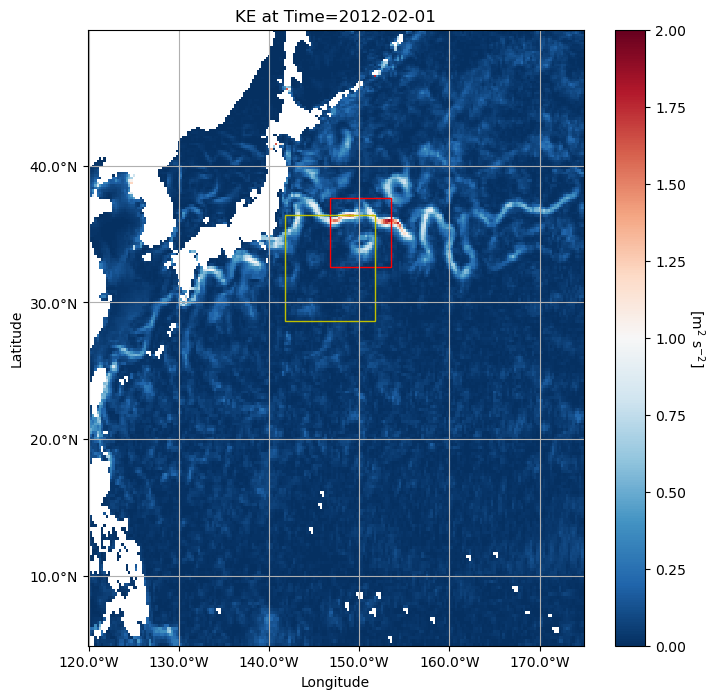

In [38]:
plot_with_polygon(tmp,llcw_test1, i1, j1, i2, j2, half_sbox)

In [39]:
%%time
process_netCDF_files(number, j1, j2, i1, i2, inter, llcw_test1, C, D, g, a, m0, ex, e)
# 得到一个个的独立的mat文件

CPU times: user 16.3 s, sys: 16.6 ms, total: 16.3 s
Wall time: 18.1 s


[8.56659944]


/tmp/ipykernel_653/4133043139.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  ax2.set_xticklabels([str(round(1 / x, 2)) for x in ax1.get_xticks()])


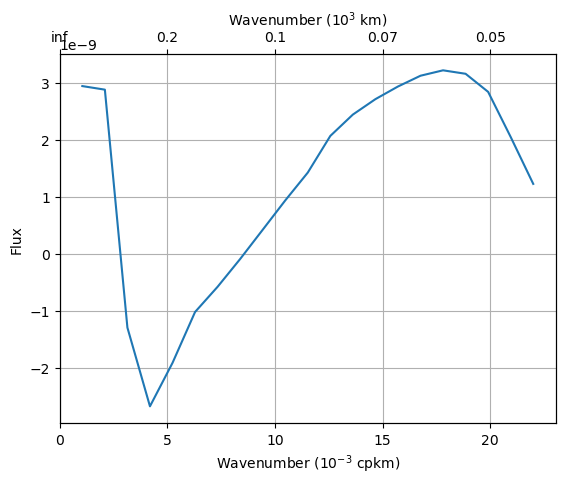

In [40]:
# 把全部的mat文件进行取平均
aggregate_and_save_flux_data('./output/', number, './output/final_aggregated_data.mat')
# 仅绘图
inject_scale = plot_aggregated_data('./output/final_aggregated_data.mat')